In [1]:
!pip install pybamm

zsh:1: command not found: pip


In [2]:
!pip install niceplots

zsh:1: command not found: pip


In [3]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import niceplots
plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()


ModuleNotFoundError: No module named 'pybamm'

# Galvanostatic discharge

2025-09-06 15:44:10.852 - [WARNING] callbacks.on_experiment_infeasible_event(254): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 1C for 1 hours'. The returned solution only contains up to step 1 of cycle 1. 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 1C for 1 hours'. The returned solution only contains up to step 1 of cycle 1. 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

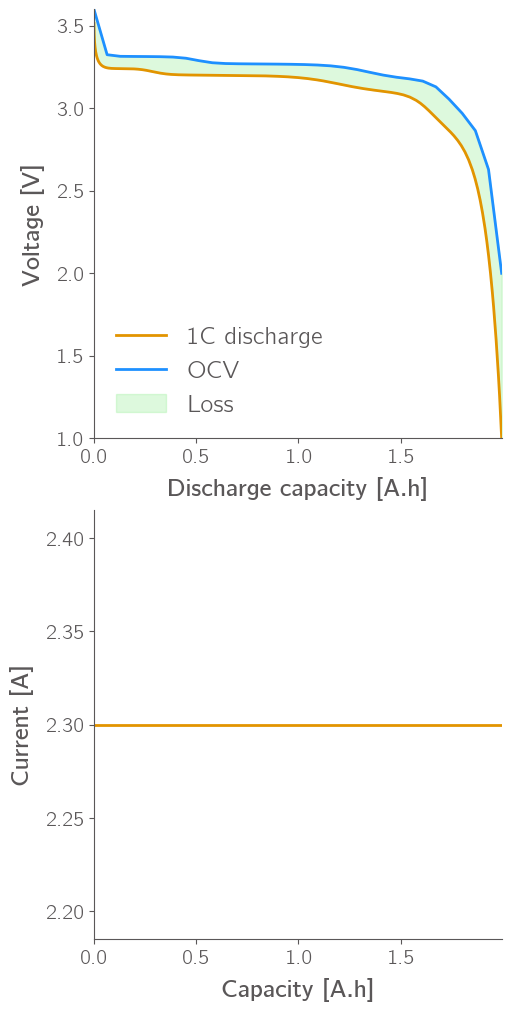

In [33]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

fig, ax = plt.subplots(2, 1, figsize=(5, 10))
# ax[0].plot(time, voltage, color=colors[0])
# ax[0].set_ylabel("Voltage [V]")
# ax[0].set_xlabel("Time [s]")
# ax[1].plot(time, current, color=colors[0])
# ax[1].set_ylabel("Current [A]")
# ax[1].set_xlabel("Time [s]")
# plt.show()


experiment = pybamm.Experiment(
    [
        "Discharge at 1C for 1 hours",
    ]
    )

solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()


voltage = soln["Voltage [V]"].entries
time = soln["Time [s]"].entries
current = soln["Current [A]"].entries
capacity = soln["Discharge capacity [A.h]"].entries
ax[0].plot(capacity, voltage, label="1C discharge")


soc_range = np.linspace(0.0, 1.0, 32)
x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(
    dfn_params
)
z = pybamm.InputParameter("SOC")
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = dfn_params[
    "Maximum concentration in negative electrode [mol.m-3]"
]
c_p_max = dfn_params[
    "Maximum concentration in positive electrode [mol.m-3]"
]
dfn_params.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

positive_ocp = dfn_params["Positive electrode OCP [V]"]
negative_ocp = dfn_params["Negative electrode OCP [V]"]

neg_sto = x0 + soc_range * (x100 - x0)
pos_sto = y0 - soc_range * (y0 - y100)

OCV = positive_ocp(pos_sto) - negative_ocp(neg_sto)
ax[0].plot(soc_range * capacity[-1], OCV[::-1], label="OCV")

ax[0].fill_between(
    capacity,  # x-axis values
    voltage,   # lower curve
    np.interp(capacity, soc_range * capacity[-1], OCV[::-1]),  # interpolate OCV onto same x grid
    color="lightgreen", alpha=0.3, label="Loss"
)

ax[0].legend()
ax[0].set_xlabel("Discharge capacity [A.h]")
ax[0].set_ylabel("Voltage [V]")
# plt.show()
ax[1].plot(capacity, current, color=colors[0])
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Capacity [A.h]")

plt.savefig("galvanostatic.pdf")

from google.colab import files
files.download("galvanostatic.pdf")

# plt.show()



Capacity = $\int I dt$

Internal Resistance (SOC / Time) = $\frac{OCV - V}{I}$

# Potentiostatic discharge

2.3
1682.4933680001734


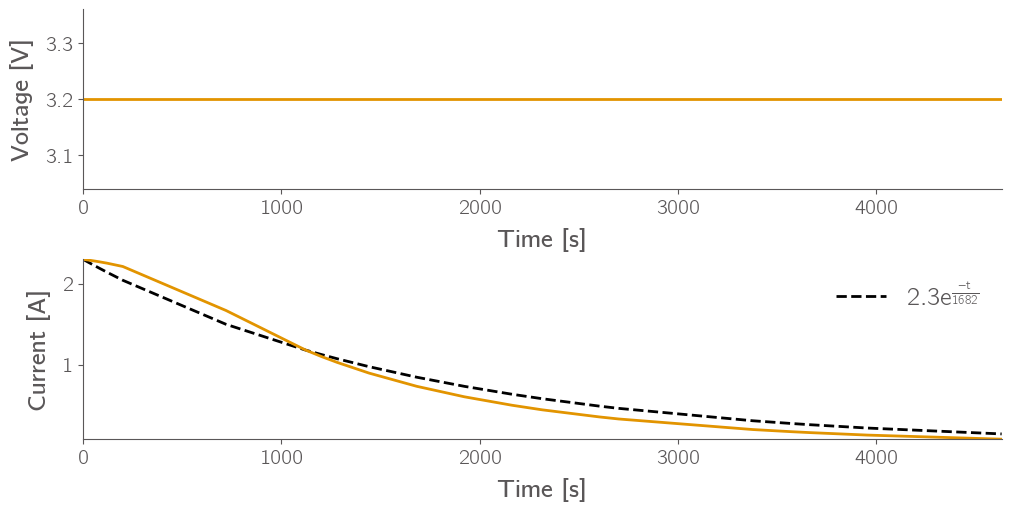

In [83]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
    [
        # "Rest for 100 seconds",
          # "Discharge at 1C for 30 seconds",
        "Discharge at 1C until 3.2 V",
        "Hold at 3.2 V until 50mA"
    ]
    )

solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()

voltage = soln["Voltage [V]"].entries
time = soln["Time [s]"].entries
current = soln["Current [A]"].entries
capacity = soln["Discharge capacity [A.h]"].entries

idx = np.where(voltage == 3.2)[0]

current_max = current[idx][0]
current_normal = current[idx] / current_max

idx2 = np.where(current_normal < 0.367)[0][0]

time_normal = time[idx] - time[idx][0]
tau = time_normal[idx2]
print(current_max)
print(tau)


fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[1].plot(time_normal, current_max * (np.exp(-time_normal / tau)), linestyle="--", color="black", label=r"2.3$e^{\frac{-t}{1682}}$")
# ax[1].plot(time_normal, current_normal, color=colors[0])
# ax[1].set_ylabel("Current

ax[0].plot(time[idx] - time[idx][0], voltage[idx], color=colors[0])
ax[0].set_ylabel("Voltage [V]")
ax[0].set_xlabel("Time [s]")
ax[1].plot(time[idx]-time[idx][0], current[idx], color=colors[0])
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Time [s]")
plt.legend()


# plt.savefig("potentiostatic.pdf")

# from google.colab import files
# files.download("potentiostatic.pdf")

# Pulse

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

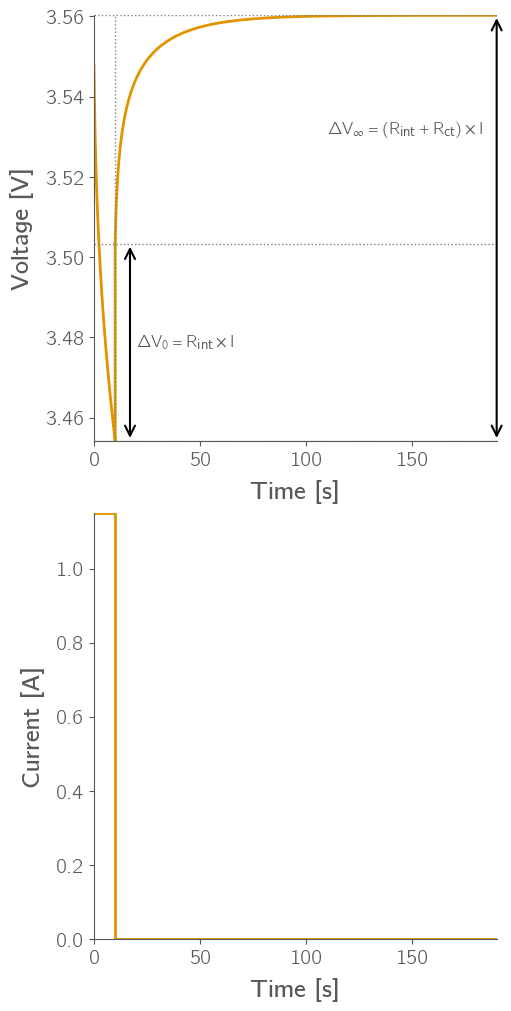

In [173]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
    [
        f"Discharge at 0.5C for 10 seconds",
        "Rest for 3 minutes",
    ]
    )


solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()

voltage = soln["Voltage [V]"].entries
time = soln["Time [s]"].entries
current = soln["Current [A]"].entries
capacity = soln["Discharge capacity [A.h]"].entries

fig, ax = plt.subplots(2,1,figsize=(5,10))
ax[0].plot(time, voltage, color=colors[0])
ax[0].set_ylabel("Voltage [V]")
ax[0].set_xlabel("Time [s]")
ax[1].plot(time, current, color=colors[0])
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Time [s]")

h_bar= 3.50328755
# Horizontal dotted reference lines
ax[0].axhline(min(voltage)-1e-4, ls=":", color="gray", lw=1)
ax[0].axhline(h_bar, ls=":", color="gray", lw=1)
ax[0].axhline(max(voltage) + 1e-4, ls=":", color="gray", lw=1)

# Vertical dotted line at t=10
ax[0].axvline(10, ls=":", color="gray", lw=1)

# Δv0 arrow
ax[0].annotate(
    "", xy=(17, min(voltage)), xytext=(17, h_bar),
    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black")
)
ax[0].text(20, (min(voltage)+h_bar)/2, r"$\Delta V_0 = R_{\text{int}} \times I$", va="center", fontsize=12)

# Δv∞ arrow
ax[0].annotate(
    "", xy=(time[-1], max(voltage)), xytext=(time[-1], min(voltage)),
    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black")
)
ax[0].text(110, 0.5*(max(voltage)+h_bar), r"$\Delta V_\infty = (R_{\text{int}} + R_{\text{ct}}) \times I$", va="center", fontsize=12)

plt.savefig("pulse.pdf")

from google.colab import files
files.download("pulse.pdf")



In [159]:
print(voltage)

[3.54793825 3.54791302 3.54788781 3.54783748 3.54773716 3.54753788
 3.5471446  3.54637802 3.5456309  3.5449022  3.5434864  3.54213179
 3.5395946  3.53726096 3.53510314 3.53309733 3.52947243 3.52625696
 3.52334872 3.52069237 3.5182285  3.51549183 3.51297756 3.5106165
 3.50837807 3.50627701 3.50429147 3.50238649 3.50056545 3.49881049
 3.49712875 3.49549826 3.49392716 3.49092189 3.48808419 3.48539232
 3.48282809 3.47802987 3.47359411 3.46944592 3.46554833 3.46184905
 3.45837749 3.45502142 3.45424475 3.50328755 3.50340496 3.50349826
 3.5036828  3.5040435  3.50473495 3.50539948 3.50603891 3.50726508
 3.50841235 3.51049369 3.51232814 3.51395922 3.51542316 3.51794243
 3.51986883 3.52169669 3.52331481 3.52476499 3.52607687 3.52727332
 3.52837279 3.53033555 3.53204673 3.53355905 3.53491073 3.53613123
 3.53724258 3.53920248 3.5408816  3.54233879 3.54361954 3.54475792
 3.54670389 3.54830942 3.54965344 3.55079477 3.551778   3.55263451
 3.55405549 3.55507316 3.55590152 3.5565839  3.55715183 3.55762

Fitting 1RC circuit, procedure similar to HW

# OCV (GITT)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

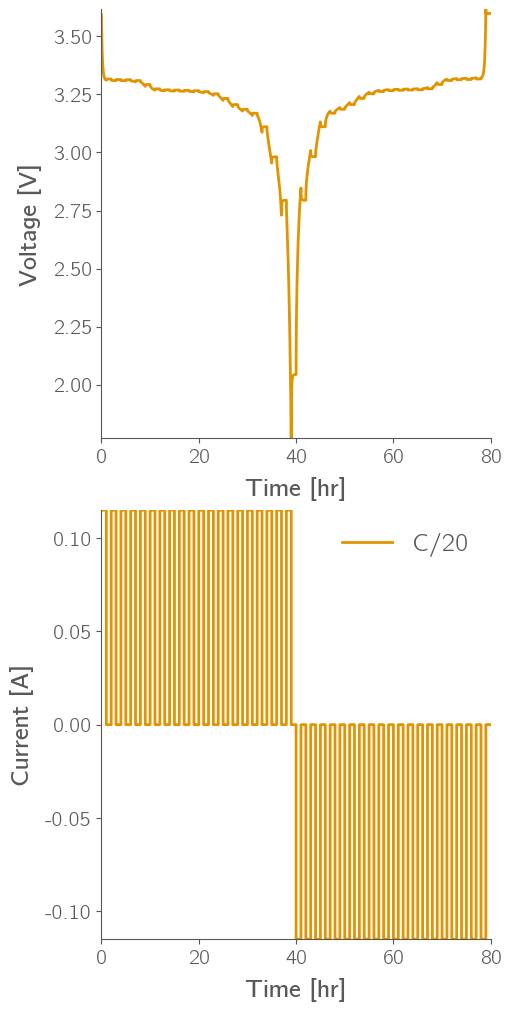

In [74]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

fig, ax = plt.subplots(2, 1, figsize=(5, 10))

experiment = pybamm.Experiment(
    ["Discharge at C/20 for 1 hour", "Rest for 1 hour"] * 20
    +  ["Charge at C/20 for 1 hour", "Rest for 1 hour"] * 20
)

solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()


voltage = soln["Voltage [V]"].entries
time = soln["Time [s]"].entries / 3600
current = soln["Current [A]"].entries
capacity = soln["Discharge capacity [A.h]"].entries

ax[0].plot(time, voltage)
ax[0].legend()
ax[0].set_xlabel("Time [hr]")
ax[0].set_ylabel("Voltage [V]")
# plt.show()
ax[1].plot(time, current, color=colors[0], label="C/20")
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Time [hr]")
plt.legend()

plt.savefig("gitt.pdf")

from google.colab import files
files.download("gitt.pdf")

plt.show()



# HPPC

2025-09-06 21:25:07.271 - [WARNING] callbacks.on_experiment_infeasible_event(254): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 0.5C for 12 minutes'. The returned solution only contains up to step 1 of cycle 56. 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 0.5C for 12 minutes'. The returned solution only contains up to step 1 of cycle 56. 


Text(0.5, 0, 'Time [s]')

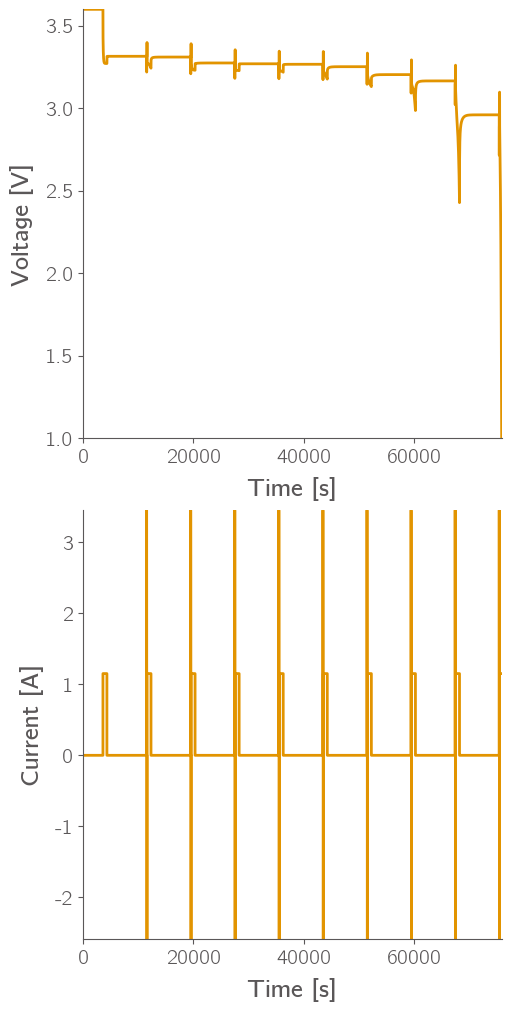

In [256]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
      ["Rest for 1 hour",
       "Discharge at 0.5C for 12 minutes",
        "Rest for 1 hour"]+
     [
        "Rest for 1 hour",
        "Discharge at 1.5C for 10 seconds",
        "Rest for 50 seconds",
        "Charge at 1.125C for 10 seconds",
        "Discharge at 0.5C for 12 minutes",
        "Rest for 1 hour"
    ]*9
    )


solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()

voltage_hppc = soln["Voltage [V]"].entries
time_hppc = soln["Time [s]"].entries
current_hppc = soln["Current [A]"].entries
capacity_hppc = soln["Discharge capacity [A.h]"].entries

fig, ax = plt.subplots(2, 1, figsize=(5, 10))
ax[0].plot(time_hppc, voltage_hppc, color=colors[0])
ax[0].set_ylabel("Voltage [V]")
ax[0].set_xlabel("Time [s]")
ax[1].plot(time_hppc, current_hppc, color=colors[0])
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Time [s]")


# plt.savefig("hppc.pdf")

# from google.colab import files
# files.download("hppc.pdf")

# plt.show()

Text(0.5, 0, 'Time [s]')

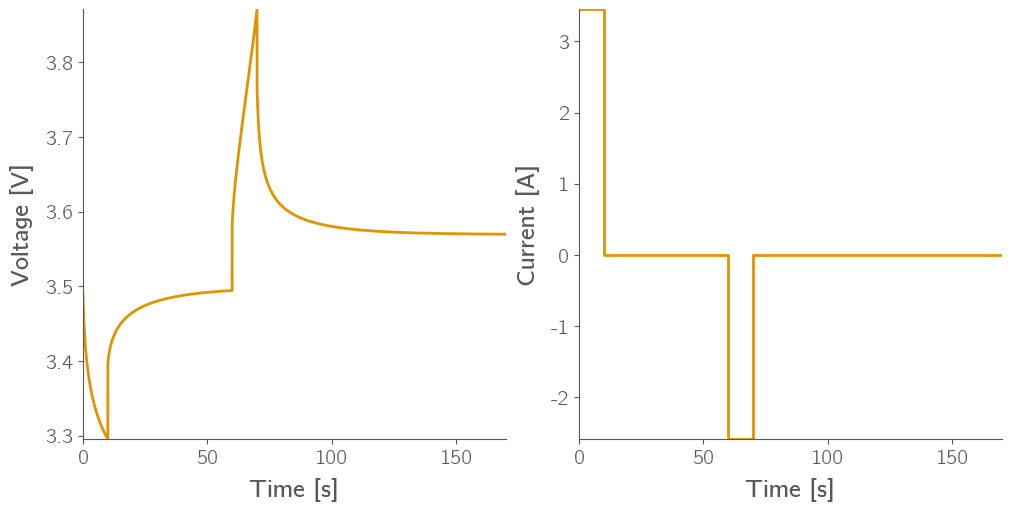

In [257]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
     [
        "Discharge at 1.5C for 10 seconds",
        "Rest for 50 seconds",
        "Charge at 1.125C for 10 seconds",
        "Rest for 100 seconds",
    ]*1
    )



solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()

voltage = soln["Voltage [V]"].entries
time = soln["Time [s]"].entries
current = soln["Current [A]"].entries
capacity = soln["Discharge capacity [A.h]"].entries

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(time, voltage, color=colors[0])
ax[0].set_ylabel("Voltage [V]")
ax[0].set_xlabel("Time [s]")
ax[1].plot(time, current, color=colors[0])
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Time [s]")


# plt.savefig("hppc_zoom.pdf")

# from google.colab import files
# files.download("hppc_zoom.pdf")

In [258]:
idx1 = np.where(current > 3.0)[0]
idx2 = np.where(current < -2.0)[0]

In [259]:
volt_pdisc = voltage[idx1[-1]+1:idx2[0]]
time_pdisc = time[idx1[-1]+1:idx2[0]]

volt_offset = volt_pdisc[0]
volt_pdisc = volt_pdisc - min(volt_pdisc)
volt_scaling = max(volt_pdisc)

volt_pdisc = volt_pdisc / max(volt_pdisc)

t_offset = time_pdisc[0]
time_pdisc = time_pdisc - time_pdisc[0]

tau_idx = np.where(volt_pdisc > 0.67)[0][0]
tau_disc = time_pdisc[tau_idx]
print(tau_idx)

32


In [260]:
volt_pchar = voltage[idx2[-1]+1:]
time_pchar = time[idx2[-1]+1:]

volt_offset_char = min(volt_pchar)
volt_pchar = volt_pchar - min(volt_pchar)
volt_scaling_char = max(volt_pchar)

volt_pchar = volt_pchar / max(volt_pchar)

t_offset_char = time_pchar[0]
time_pchar = time_pchar - time_pchar[0]

tau_idx = np.where(volt_pchar < 0.33)[0][0]
tau_char = time_pchar[tau_idx]
print(tau_char)

4.970551503580026


3.3967386204932577 0.09764755095845468 10.000000000000002 9.16497998611378
3.569689186821537 0.19858895192836235 70.00000000000001 4.970551503580026


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

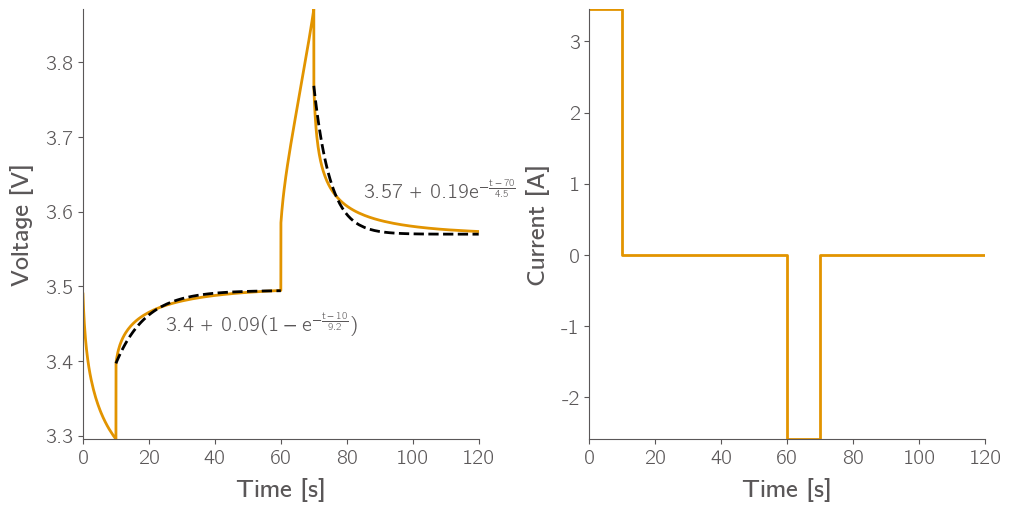

In [261]:
dfn_params = pybamm.ParameterValues("Prada2013")
dfn_model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
     [
        "Discharge at 1.5C for 10 seconds",
        "Rest for 50 seconds",
        "Charge at 1.125C for 10 seconds",
        "Rest for 50 seconds",
    ]*1
    )



solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(dfn_model, parameter_values=dfn_params, experiment=experiment, solver=solver)
soln = sim.solve()

voltage = soln["Voltage [V]"].entries
time = soln["Time [s]"].entries
current = soln["Current [A]"].entries
capacity = soln["Discharge capacity [A.h]"].entries

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(time, voltage, color=colors[0])
ax[0].set_ylabel("Voltage [V]")
ax[0].set_xlabel("Time [s]")
ax[1].plot(time, current, color=colors[0])
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Time [s]")

ax[0].plot(time[idx1[-1]+1:idx2[0]], volt_offset + volt_scaling*(1-np.exp(-(time[idx1[-1]+1:idx2[0]] - t_offset)/tau_disc)), color="black", linestyle="--")
ax[0].plot(time[idx2[-1]+1:], volt_offset_char + volt_scaling_char*(np.exp(-(time[idx2[-1]+1:] - t_offset_char)/tau_char)), color="black", linestyle="--")

print(volt_offset, volt_scaling, t_offset, tau_disc)
print(volt_offset_char, volt_scaling_char, t_offset_char, tau_char)
ax[0].text(25, 3.45, r"3.4 + 0.09($1 - e^{-\frac{t-10}{9.2}}$)", va="center", fontsize=15)
ax[0].text(85, 3.63, r"3.57 + 0.19$e^{-\frac{t-70}{4.5}}$", va="center", fontsize=15)

plt.savefig("hppc_zoom.pdf")

from google.colab import files
files.download("hppc_zoom.pdf")

In [266]:
idx1 = np.where(current_hppc > 3.0)[0]
idx2 = np.where(current_hppc < -2.0)[0]

Text(0, 0.5, 'Power [W]')

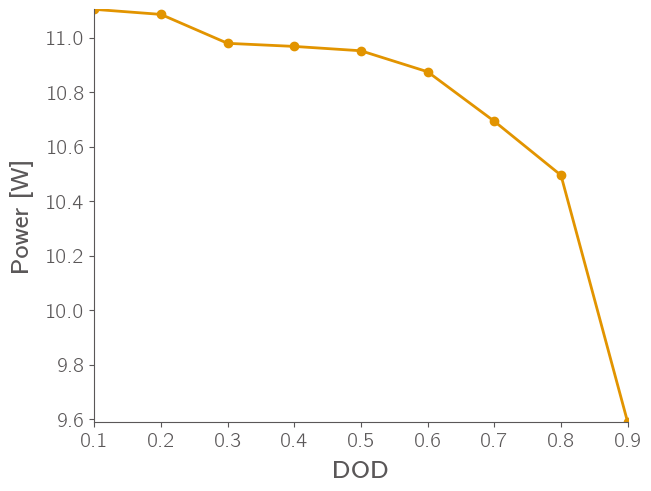

In [267]:
breaks = np.flatnonzero(np.diff(idx1) != 1)

# Start/end indices of each contiguous block
starts = np.r_[0, breaks + 1]
ends   = np.r_[breaks, len(idx1) - 1]

# (start, end) value pairs
value_pairs = np.column_stack((idx1[starts], idx1[ends]))
voltage_lims = voltage_hppc[value_pairs]

v_avg = np.mean(voltage_lims, axis=1)
power = v_avg * current_hppc[idx1][0]
plt.plot(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), power)
plt.scatter(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), power)

plt.xlabel("DOD")
plt.ylabel("Power [W]")
# plt.savefig("hppc_power.pdf")

# from google.colab import files
# files.download("hppc_power.pdf")

In [283]:
idx_before_jumps = np.where(np.diff(idx1) > 2)[0]
disc_end = np.concatenate((idx1[idx_before_jumps], [idx1[-1]]))
disc_start = np.concatenate(([idx1[0]], idx1[idx_before_jumps+1]))-1


In [293]:
idx_before_jumps = np.where(np.diff(idx2) > 2)[0]
char_end = np.concatenate((idx2[idx_before_jumps], [idx2[-1]]))
char_start = np.concatenate(([idx2[0]], idx2[idx_before_jumps+1]))-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

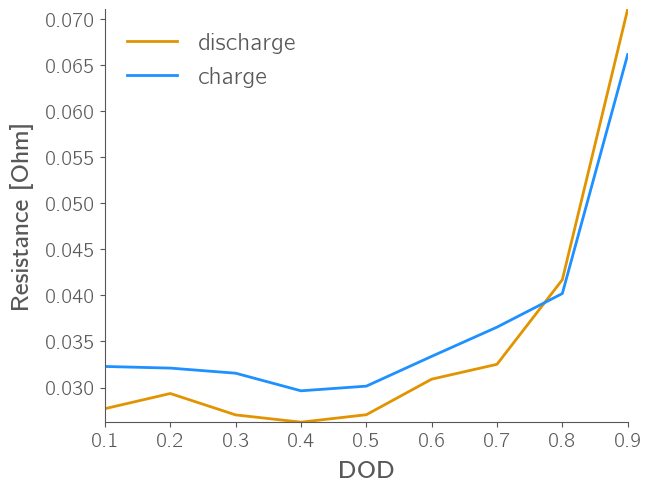

In [330]:
R_disc = np.abs((voltage_hppc[disc_end] - voltage_hppc[disc_start]) / (current_hppc[disc_end] - current_hppc[disc_start]))
R_char = np.abs((voltage_hppc[char_end] - voltage_hppc[char_start]) / (current_hppc[char_end] - current_hppc[char_start]))
plt.plot(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), R_disc, label="discharge")
plt.plot(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), R_char, label="charge")
plt.xlabel("DOD")
plt.ylabel("Resistance [Ohm]")
plt.legend()
plt.savefig("hppc_R.pdf")

from google.colab import files
files.download("hppc_R.pdf")

In [331]:
parameter_values = pybamm.ParameterValues("Prada2013")
delta = 0.1

soc_range = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) - delta
soc_range_char = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) - (1./240.) - delta
# soc_range = np.linspace(0.0, 1.0, 32)
x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(
    parameter_values
)
z = pybamm.InputParameter("SOC")
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = parameter_values[
    "Maximum concentration in negative electrode [mol.m-3]"
]
c_p_max = parameter_values[
    "Maximum concentration in positive electrode [mol.m-3]"
]
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

positive_ocp = dfn_params["Positive electrode OCP [V]"]
negative_ocp = dfn_params["Negative electrode OCP [V]"]

neg_sto = x0 + soc_range * (x100 - x0)
pos_sto = y0 - soc_range * (y0 - y100)
OCV = positive_ocp(pos_sto) - negative_ocp(neg_sto)

neg_sto = x0 + soc_range_char * (x100 - x0)
pos_sto = y0 - soc_range_char * (y0 - y100)
OCV_char = positive_ocp(pos_sto) - negative_ocp(neg_sto)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

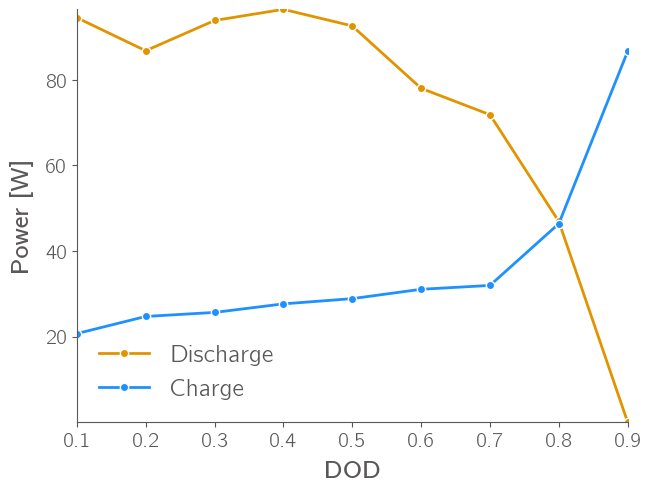

In [333]:
V_min = 2.0
power_disc = V_min * (OCV[::-1] - V_min) / R_disc
power_char = 3.5 * (3.5 - OCV_char[::-1]) / R_char

plt.plot(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), power_disc, label="Discharge", marker="o")

plt.plot(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), power_char, label="Charge", marker="o")
plt.xlabel("DOD")
plt.ylabel("Power [W]")
plt.legend()
plt.savefig("hppc_power.pdf")
files.download("hppc_power.pdf")

We can test power capabilities at every 10% DOD of the cell.

We can compute $R_{disc}$ and $R_{charge}$, from a simple $\Delta V/I$ formula and get the resistances as functions fo SOC.

If we assume a simple internal resistance model:

We can express the current as:
$I  = \frac{OCV(Z) - V}{R}$

then power is V * I,

for discharge power pulse we clamp V to $V_{min}$ and for charge $V_{max}$.

# Warburg impedance (CPE)

GITT/PITT? Diffusion coefficient extraction for warburg? Might be too much.

We can show GITT as a technique to extract OCV, RC values and diffusion coefficient all in one experiment.

# EIS

In [3]:
!pip install pybammeis==0.1.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.1 MB/s eta 0:00:00


In [4]:
!pip install impedance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.3 MB/s eta 0:00:00


In [5]:
from impedance.visualization import plot_nyquist
import pybammeis

[0.00105143 0.03806194 0.40541924]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

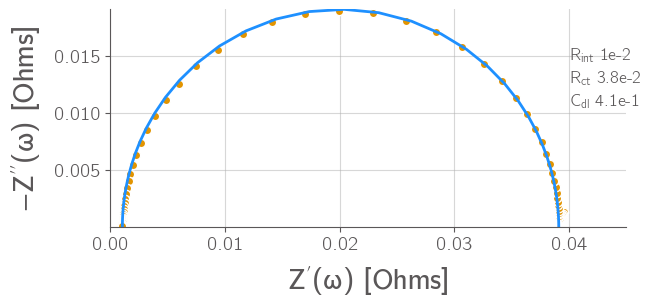

In [15]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
parameter_values = pybamm.ParameterValues("Prada2013")
dfn_params = pybamm.ParameterValues("Prada2013")

soc_range = np.linspace(0.0, 1.0, 32)
x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(
    parameter_values
)
z = pybamm.InputParameter("SOC")
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = parameter_values[
    "Maximum concentration in negative electrode [mol.m-3]"
]
c_p_max = parameter_values[
    "Maximum concentration in positive electrode [mol.m-3]"
]
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

positive_ocp = dfn_params["Positive electrode OCP [V]"]
negative_ocp = dfn_params["Negative electrode OCP [V]"]

neg_sto = x0 + soc_range * (x100 - x0)
pos_sto = y0 - soc_range * (y0 - y100)



# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
# initial_guess = fit_params.initial_guess
frequencies = np.logspace(
    -1.5, 4, 80
)

fig, ax = plt.subplots()
# plt.ylim(0.0, 0.03)
plt.xlim(0.0, 0.045)

soc = 0.8
soln = eis_sim.solve(frequencies, inputs={"SOC": soc})

z = soln.real + 1j * soln.imag
plot_nyquist(z, fmt="o", ax=ax)

from impedance.models.circuits import CustomCircuit
circuit_defn = "R0-p(R1,C1)"

circuit = CustomCircuit(circuit_defn, initial_guess=[0.001, 0.002, 1e5])
circuit.fit(frequencies, z, weight_by_modulus=True)
z_fit = circuit.predict(frequencies)
plot_nyquist(z_fit, fmt="-", ax=ax)
print(circuit.parameters_)
R0, R1, C1 = circuit.parameters_

ax.text(0.04, 0.015, r"$R_{int}$ 1e-2", va="center", fontsize=12)
ax.text(0.04, 0.013, r"$R_{ct}$ 3.8e-2", va="center", fontsize=12)
ax.text(0.04, 0.011, r"$C_{dl}$ 4.1e-1", va="center", fontsize=12)

# ax.text(0.022, 0.027, r"$Zo$ 2.9e-2", va="center", fontsize=12)
# ax.text(0.022, 0.025, r"$\tau$ 1.54e-3", va="center", fontsize=12)


# plt.legend(["EIS"])

plt.savefig("eis.pdf")
from google.colab import files
files.download("eis.pdf")


[1.23004375e-03 2.00027275e-03 1.00000000e+05 1.35588602e-03]


Text(0.01, 0.023, '$C_{dl}$ 4.07e-1')

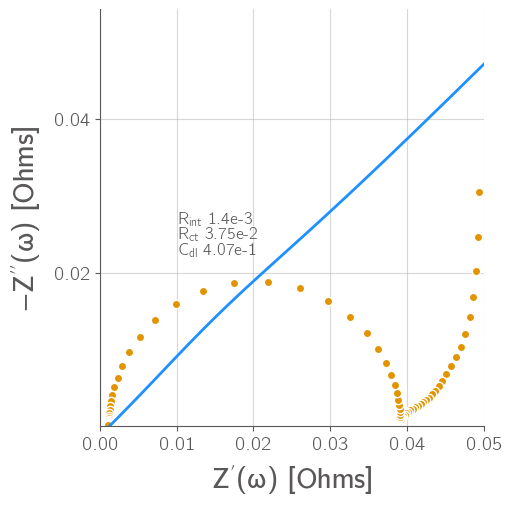

In [362]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
parameter_values = pybamm.ParameterValues("Prada2013")

soc_range = np.linspace(0.0, 1.0, 32)
x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(
    parameter_values
)
z = pybamm.InputParameter("SOC")
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = parameter_values[
    "Maximum concentration in negative electrode [mol.m-3]"
]
c_p_max = parameter_values[
    "Maximum concentration in positive electrode [mol.m-3]"
]
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

positive_ocp = dfn_params["Positive electrode OCP [V]"]
negative_ocp = dfn_params["Negative electrode OCP [V]"]

neg_sto = x0 + soc_range * (x100 - x0)
pos_sto = y0 - soc_range * (y0 - y100)



# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
# initial_guess = fit_params.initial_guess
frequencies = np.logspace(
    -4, 4, 80
)

fig, ax = plt.subplots(figsize=(5, 7))
# plt.ylim(0.0, 0.03)
plt.xlim(0.0, 0.05)

soc = 0.8
soln = eis_sim.solve(frequencies, inputs={"SOC": soc})

z = soln.real + 1j * soln.imag
plot_nyquist(z, fmt="o", ax=ax)

from impedance.models.circuits import CustomCircuit
circuit_defn = "R0-p(R1,C1)-W"

circuit = CustomCircuit(circuit_defn, initial_guess=[0.001, 0.002, 1e5, 1e-3])
circuit.fit(frequencies, z, weight_by_modulus=True)
z_fit = circuit.predict(frequencies)
plot_nyquist(z_fit, fmt="-", ax=ax)
print(circuit.parameters_)
R0, R1, C1, Wo = circuit.parameters_

ax.text(0.01, 0.027, r"$R_{int}$ 1.4e-3", va="center", fontsize=12)
ax.text(0.01, 0.025, r"$R_{ct}$ 3.75e-2", va="center", fontsize=12)
ax.text(0.01, 0.023, r"$C_{dl}$ 4.07e-1", va="center", fontsize=12)

# ax.text(0.022, 0.027, r"$Zo$ 2.9e-2", va="center", fontsize=12)
# ax.text(0.022, 0.025, r"$\tau$ 1.54e-3", va="center", fontsize=12)


# plt.legend(["EIS"])

# plt.savefig("eis.pdf")

# from google.colab import files
# files.download("eis.pdf")
